# Задание
Обучить **сиамскую сеть** для верификации лиц на датасете **LFW**

***

In [1]:
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.manifold import TSNE
from collections import Counter

***********************

# Load data. Preprocessing

In [3]:
train_ds, test_ds = tfds.load('lfw', as_supervised=True, split=[
                              'train[:90%]', 'train[90%:]'])
len(train_ds), len(test_ds)

(11910, 1323)

In [4]:
# уменьшение датасета для возможности визуализации - отбор 10 персон
person_list = [b'George_W_Bush',
               b'Colin_Powell',
               b'Tony_Blair',
               b'Donald_Rumsfeld',
               b'Gerhard_Schroeder',
               b'Ariel_Sharon',
               b'Hugo_Chavez',
               b'Junichiro_Koizumi',
               b'Jean_Chretien',
               b'John_Ashcroft'
               ]

person_dict = {i: person_list[i] for i in range(len(person_list))}

In [5]:
# отбор 3-х изображений для теста
person_test_list = [b'George_W_Bush',
                    b'Hugo_Chavez',
                    b'Jean_Chretien'
                    ]
img_test_list = []
label_test_list = []
for example in test_ds:
    person = example[0].numpy()
    if person in person_test_list:
        person_test_list.remove(person)
        img_test_list.append(example[1])
        label_test_list.append(person)
        if len(person_test_list) == 0:
            break
img_test_list = np.array(img_test_list)
label_test_list = np.array(label_test_list)

In [6]:
INP_SIZE = 250
BATCH_SIZE = 32
NUM_EPOCHS = 120
LEARNING_RATE = 0.0001
MARGIN = 10.0
EMB_SIZE = 64

In [7]:
def prepare_images(img, label):
    img = tf.cast(img, tf.float32)/255.
    if (img.shape[0] != INP_SIZE) or (img.shape[1] != INP_SIZE):
        img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    return img, label

In [8]:
def choose_img(person_list, ds):
    img_list = []
    label_list = []
    for example in ds:
        person = example[0].numpy()
        if person in person_list:
            img_list.append(example[1])
            label_list.append(person_list.index(person))
    dataset = tf.data.Dataset.from_tensor_slices((img_list, label_list))

    return dataset, np.array(img_list), np.array(label_list)

In [9]:
train_ds, train_x, train_y = choose_img(person_list, train_ds)

In [10]:
train_x = train_x.astype(np.float32) / 255.
test_x = img_test_list.astype(np.float32) / 255.

In [11]:
sample = [x for x in iter(train_ds.take(10))]
len(train_ds)

1319

In [12]:
def plot_sample(sample):
    N = len(sample)
    fig = plt.figure(figsize=(16, 9))
    for j in range(len(sample)):
        ax = fig.add_subplot(4, 5, j+1)
        ax.imshow(sample[j][0])
        plt.subplots_adjust(wspace=0, hspace=0.3)
        plt.xticks([])
        plt.yticks([])
        if type(sample[j][1]) != np.bytes_:
            title = person_dict[sample[j][1].numpy()]
        else:
            title = sample[j][1]
        plt.title(title.decode().replace("_", " "))
        plt.grid(False)
    plt.show()

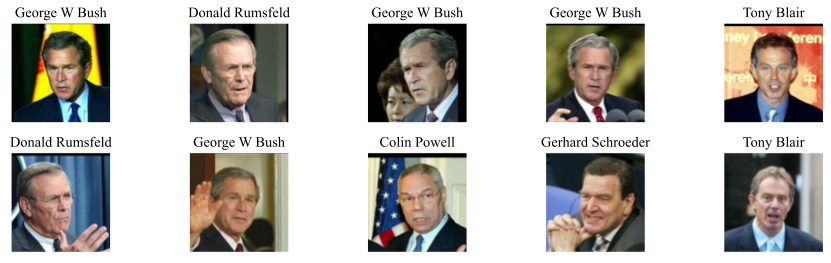

In [13]:
plot_sample(sample)

In [14]:
train_ds = train_ds.map(prepare_images)
train_ds = train_ds.shuffle(buffer_size=10000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# Contrastive Loss
def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d = tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)

    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

# MODEL BUILD. TRAIN

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(EMB_SIZE, activation=None)
])

In [17]:
checkpoint_dir = './training_siam_checkpoints'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

In [18]:
%%time

for iteration, (images, labels) in enumerate(train_ds):

    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)

        if iteration == 0:
            min_loss = loss_value

    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if loss_value <= min_loss:
        min_loss = loss_value
        checkpoint_prefix = os.path.join(
            checkpoint_dir, "ckpt_", str(iteration))
#             checkpoint.save(file_prefix=checkpoint_prefix)

    if iteration % 500 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 77.80274963378906
[500] Loss: 26.930830001831055
[1000] Loss: 13.769131660461426
[1500] Loss: 3.1332993507385254
[2000] Loss: 2.5213356018066406
[2500] Loss: 2.2212917804718018
[3000] Loss: 1.441986083984375
[3500] Loss: 1.8095765113830566
[4000] Loss: 0.7473131418228149
[4500] Loss: 0.0171649269759655
Wall time: 25min 32s


# TEST RESULT

In [19]:
# restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

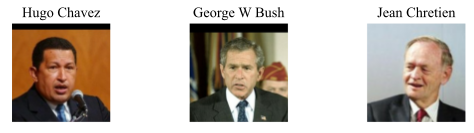

In [20]:
# изображения для тестирования
plot_sample(list(zip(test_x, label_test_list)))

In [21]:
person_emb_train = model.predict(train_x)
person_emb_test = model.predict(test_x)

In [22]:
emb_full = np.concatenate((person_emb_train, person_emb_test), axis=0)
tsne_emb = TSNE(n_components=2)
emb_2D = tsne_emb.fit_transform(emb_full)

In [23]:
def draw_embeddings(X_embedded, targets, test_img_emb, test_labels):
    cmap = ['pink', 'darkred', 'blue']
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:, 0], X_embedded_class[:, 1],
                    label=person_dict[class_idx].decode().replace("_", " "))
    for num, img in enumerate(test_img_emb):
        plt.scatter(img[0], img[1], s=275, c=cmap[num], edgecolors='white',
                    linewidths=2, label=test_labels[num].decode().replace("_", " "))
    plt.legend(loc='best')
    plt.grid(True)

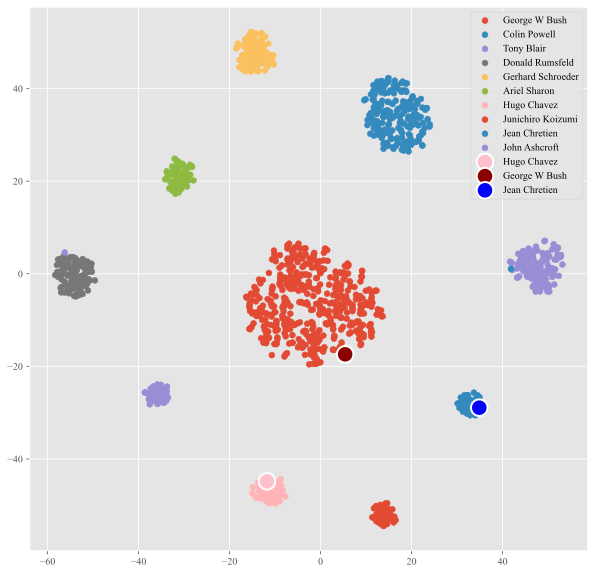

In [24]:
draw_embeddings(emb_2D[:-3], train_y, emb_2D[-3:], label_test_list)

In [25]:
# В двумерном представлении положение эмбеддингов тестовых изображений совпало с положением соответсвующих эмбеддингов после обучения